# Imports and images

In [2]:
# Imports
import numpy as np
import math
from hausdorff import hausdorff_distance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from scipy import stats
import sklearn.metrics

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
# from gudhi import bottleneck_distance
# import gudhi as gd
# from tqdm import tqdm
# from mpl_toolkits.mplot3d import Axes3D
# import networkx as nx
 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Grab image from files
c1_names = glob.glob('../images/*C1*.png')
c4_names = glob.glob('../images/*C4*.png')
test_name = glob.glob('../images/test*.png')
print(c1_names)
print(c4_names)
print(test_name)

['../images\\C1 curly arrow.png', '../images\\C1 horsehex.png', '../images\\C1 horseshoe.png', '../images\\C1 spiral.png', '../images\\C1arrows.png', '../images\\C1bigarrows.png']
['../images\\C4pinwheel.png']
['../images\\testDiag.png', '../images\\testPersis.png', '../images\\testPersisC2.png']


In [ ]:
img = Image.open(c1_names[5])
img = img.convert('L')

img2 = Image.open(c1_names[5])
img2 = img2.convert('L')
img2 = img2.resize((3809*3,1614*3), resample = PIL.Image.Resampling.BOX)

arrowimg = Image.open(c1_names[4]).convert('L')
img4 = Image.open(c4_names[0])
img4 = img4.convert('L')

testimg = Image.open(test_name[1]).convert('L')
testimg2 = Image.open(test_name[2]).convert('L')
testimg3 = Image.open(test_name[0]).convert('L')
#img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))
#img.show()

# Functions:lens, metrics, misc

In [3]:
# wrapper for degree weighted metric
def degree_wrapper(alphaMod = 1, metric='euclidean'):
    def second_layer(arrayOne, arrayTwo):
        mod1 = arrayOne[1:].reshape(1, -1)
        mod2 = arrayTwo[1:].reshape(1, -1)
        d1 = arrayOne[0]
        d2 = arrayTwo[0]
        
        ret = paired_distances(mod1, mod2, metric = metric)
        alpha = (180 - abs(abs(d1 - d2) - 180)) / 180
        # alpha is a value between 0 and 1; 1 means 180 degrees away, 0 0 degrees away
        # current curve is linear; this is probably bad
        return ret[0]* (alpha * alphaMod + 1)
    return second_layer

In [4]:
 one = np.array([0, 2, 0, 0])
 two = np.array([270, 0, 0, 0])
 degree_wrapper()(one,two)

3.0

In [5]:
# wrapper for hausdorff so we can feed it into ripser
def hausdorff_wrapper(lensSize, metric='manhattan'):
    (x, y) = lensSize
    def second_layer(arrayOne, arrayTwo):        
        arrayOne = arrayOne.reshape((y,x))
        arrayTwo = arrayTwo.reshape((y,x))
        return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
    return second_layer

In [6]:
# def hausdorff_test(lensSize, metric='manhattan'):
#     (x, y) = lensSize
#     def second_layer(arrayOne, arrayTwo):
#         arrayOne = arrayOne.reshape((y,x))
#         Image.fromarray(arrayOne).show()
#         arrayTwo = arrayTwo.reshape((y,x))
#         return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
#     return second_layer
# test_img = img4.crop((0,0,20,30))
# test_img.show()
# test_arr = np.asarray(test_img)
# hausdorff_test((20,30))(test_arr, test_arr)

In [7]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("../images/dataset/"+str(counter)+".png")
        counter+=1
def store_degree_snapshots(image_ls, lens):
    counter = 0
    (x, y) = lens
    for img1 in image_ls:
        arr = img1[1:]
        arr = arr.astype(np.int8)
        arr = np.reshape(arr, (y,x))
        image = Image.fromarray(arr, 'L')
        image.save("../images/dataset/"+str(counter)+".png")
        counter+=1

In [8]:
# see how many points are persisting
def persistingPoints(res,simpDim = 1):
    Hn = res['dgms'][simpDim].tolist() # all intervals in simpDim
    d = []
    for pair in Hn: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in Hn
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:6])

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [9]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    (lx, ly) = lens_sz
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lx/2.0 +x
    lens_corner_y=height/2.0 - ly/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
#     if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lx>length or lens_corner_y+ly>height):
#         print("I came off the page!")
#         return False
    return ret_img

In [10]:
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [11]:
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [12]:
def randIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-max(lens_sz))/2.0
    degrees = rng.uniform(0.0,360.0, size = degree_num)
    j = 0
    
    for d in degrees:
        #print(j)
        j = j + 1
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    for k in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [13]:
def squareIso(img, lens_sz, square_mod = 0):
    
    image_list = []

    if not square_mod:
        lens_range = ((min(img.size)/math.sqrt(2))-max(lens_sz))/2.0
    else:
        lens_range = square_mod
        
    for x in np.arange((-1)*lens_range, lens_range, 1):
        for y in np.arange((-1)*lens_range, lens_range, 1):
            image_list.append(translation_snapshot(img, lens_sz, (x,y)))
            
    return image_list

In [14]:
def slicedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451, center_range = 5):
    # here translation num refers to the number of points to rotate around, chosen randomly
    
    data = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = math.floor(((min(img.size)/math.sqrt(2))-max(lens_sz))/2.0)
    #center_range = math.floor(((min(img.size)/3)-max(lens_sz))/2.0)
    # center_range = 30
    degree_num = 360 / degree_num
    degrees = np.arange(0, 360, degree_num)
    w, h = img.size
    centerx = math.floor(w / 2.0)
    centery = math.floor(h / 2.0)
    lx, ly = lens_sz
    lens_corner_x=math.floor(centerx - lx/2.0)
    lens_corner_y=math.floor(centery - ly/2.0)
    zero_rotation = True

    if zero_rotation:
        for d in degrees:
            rot = img.rotate(d,resample = PIL.Image.Resampling.BICUBIC)
            rot = rot.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
            img_arr = np.asarray(rot, dtype = np.int16)
            img_arr = np.insert(img_arr, 0, d)
            data.append(img_arr.reshape(-1))
    
        temp = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
        img_arr = np.asarray(temp, dtype = np.int16)
        img_arr = np.insert(img_arr, 0, 0)
        data.append(img_arr.reshape(-1))
    
    for trans in range(translation_num):
        x = rng.integers((-1)*center_range, center_range)
        y = rng.integers((-1)*center_range, center_range)
        for d in degrees:
            rot = img.rotate(d,resample = PIL.Image.Resampling.BICUBIC, center = (centerx + x, centery + y))
            rot = rot.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
            img_arr = np.asarray(rot, dtype = np.int16)
            img_arr = np.insert(img_arr, 0, d)
            data.append(img_arr.reshape(-1))
        
    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
            rot = translation_snapshot(img, lens_sz, (x,y))
            img_arr = np.asarray(rot, dtype = np.int16)
            img_arr = np.insert(img_arr, 0, 0)
            data.append(img_arr.reshape(-1))
    return data

In [15]:
def imgListToArray(image_list, norm = False):
    data = []
    x=0
    for i in image_list:
        img_arr = np.asarray(i)
        if norm:
            img_arr = img_arr / 255
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

# Tests 1

In [16]:
def verticalSlice(img, lens_sz, lens_corner_x=0):
    w, h = img.size
    lx, ly = lens_sz
    if not lens_corner_x:
        lens_corner_x= (w - lx) / 2
    lens_corner_y=0
    data = []
    while lens_corner_y <= h - ly:
        snap = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
        data.append(snap)
        lens_corner_y = lens_corner_y + 1
        
    return data

In [17]:
def horizontalSlice(img, lens_sz, lens_corner_y = 0):
    w, h = img.size
    lx, ly = lens_sz
    lens_corner_y=0 
    lens_corner_x=0
    data = []
    while lens_corner_x <= h - lx:
        snap = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
        data.append(snap)
        lens_corner_x = lens_corner_x + 1
        
    return data

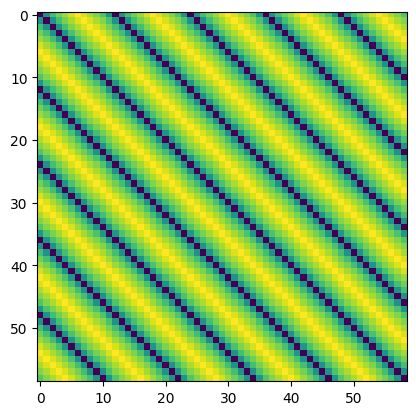

In [18]:
testimg2 = Image.open(test_name[2]).convert('L')
pimg = testimg2
data = verticalSlice(pimg, (50,50))
data = imgListToArray(data)
plt.figure()
plt.imshow(pairwise_distances(data))
plt.show()

[8.09207820892334]


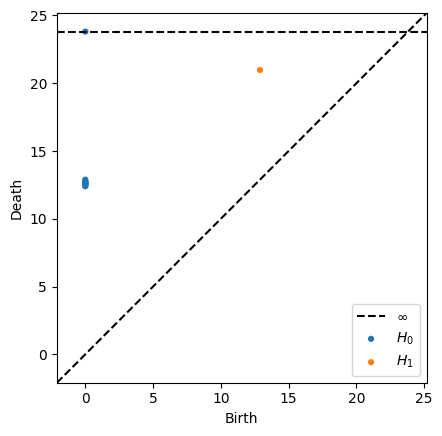

In [131]:
pimg = testimg2
data = verticalSlice(pimg, (30,30))
data = imgListToArray(data)
output = ripser(data, maxdim = 1, coeff = 2, metric = 'euclidean', do_cocycles = True)
persistingPoints(output,simpDim = 1)
plt.figure()
dgms = output['dgms']
plot_diagrams(dgms)

In [132]:
diagrams = output['dgms']
cocycles = output['cocycles']
D = output['dperm2all']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 0]+1e-5
count =  0
for k in range(cocycle.shape[0]):
    [i, j, val] = cocycle[k, :]
    if D[i, j] <= thresh:
        print([i,j])
        count += 1
print (count)

[72, 71]
[72, 59]
[72, 47]
[72, 35]
[72, 23]
[72, 11]
[71, 60]
[71, 48]
[71, 36]
[71, 24]
[71, 12]
[71, 0]
[60, 59]
[60, 47]
[60, 35]
[60, 23]
[60, 11]
[59, 48]
[59, 36]
[59, 24]
[59, 12]
[59, 0]
[48, 47]
[48, 35]
[48, 23]
[48, 11]
[47, 36]
[47, 24]
[47, 12]
[47, 0]
[36, 35]
[36, 23]
[36, 11]
[35, 24]
[35, 12]
[35, 0]
[24, 23]
[24, 11]
[23, 12]
[23, 0]
[12, 11]
[11, 0]
42


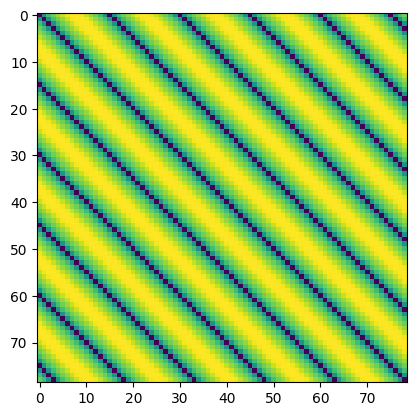

In [144]:
pimg = testimg2
data = horizontalSlice(pimg, (30,30))
data = imgListToArray(data)
temp = pairwise_distances(data)
plt.figure()
plt.imshow(temp)
plt.show()

[10.154397964477539]


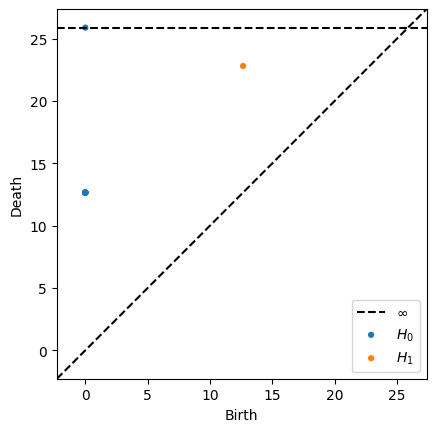

In [145]:
output = ripser(data, maxdim = 1, coeff = 2, metric = 'euclidean', do_cocycles=True)
persistingPoints(output,simpDim = 1)
plt.figure()
dgms = output['dgms']
plot_diagrams(dgms)

In [146]:
diagrams = output['dgms']
cocycles = output['cocycles']
D = output['dperm2all']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 0]+1e-5
count =  0
for k in range(cocycle.shape[0]):
    [i, j, val] = cocycle[k, :]
    if D[i, j] <= thresh:
        print([i,j])
        count += 1
print (count)

[65, 64]
[65, 49]
[65, 34]
[65, 19]
[65, 4]
[64, 50]
[64, 35]
[64, 20]
[64, 5]
[50, 49]
[50, 34]
[50, 19]
[50, 4]
[49, 35]
[49, 20]
[49, 5]
[35, 34]
[35, 19]
[35, 4]
[34, 20]
[34, 5]
[20, 19]
[20, 4]
[19, 5]
[5, 4]
25


# squareIso tests

[10.34710693359375, 7.225370407104492, 6.89996337890625, 6.413087844848633, 6.231088638305664, 6.097103118896484]


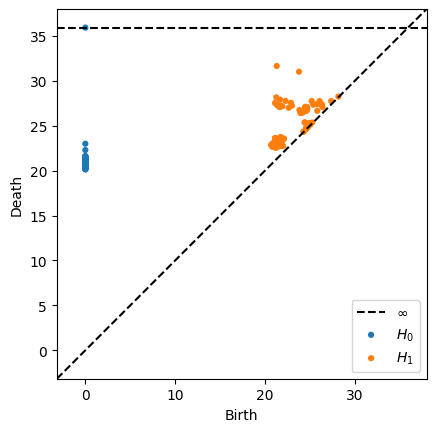

In [136]:
data = randIso(pimg,(50,50),0,0,400)
data = imgListToArray(data, True)
data = pairwise_distances(data)
output = ripser(data, maxdim = 1, coeff = 2, metric = 'euclidean', 
                do_cocycles = True, distance_matrix = True)
persistingPoints(output,simpDim = 1)
plt.figure()
dgms = output['dgms']
plot_diagrams(dgms)

In [138]:
diagrams = output['dgms']
cocycles = output['cocycles']
D = output['dperm2all']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 0]+1e-5
count =  0
for k in range(cocycle.shape[0]):
    [i, j, val] = cocycle[k, :]
    if D[i, j] <= thresh:
        print([i,j])
        count += 1
print (count)

[373, 123]
[373, 10]
[364, 123]
[364, 10]
[363, 123]
[363, 10]
[289, 123]
[289, 10]
[258, 136]
[136, 114]
10


[564.0, 396.0, 280.0, 136.0, 125.0, 125.0]


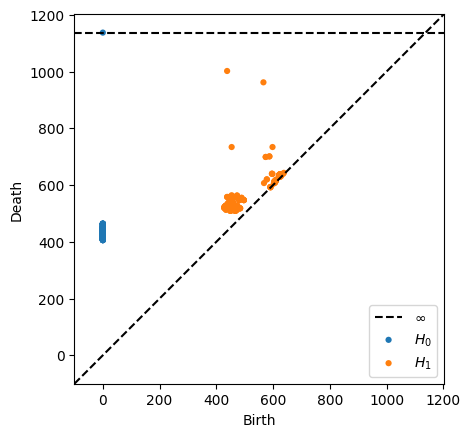

In [25]:
data = squareIso(pimg,(50,50), 20)
data = imgListToArray(data, True)
output = ripser(data, maxdim = 1, coeff = 2, metric = 'manhattan',
                do_cocycles = True)
persistingPoints(output,simpDim = 1)
plt.figure()
dgms = output['dgms']
plot_diagrams(dgms)

In [26]:
diagrams = output['dgms']
cocycles = output['cocycles']
D = output['dperm2all']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 0]+1e-5
count =  0
for k in range(cocycle.shape[0]):
    [i, j, val] = cocycle[k, :]
    if D[i, j] <= thresh:
        print([i,j])
        count += 1
print (count)

[1478, 1477]
[1478, 1465]
[1478, 1453]
[1478, 1441]
[1478, 877]
[1478, 865]
[1478, 853]
[1478, 841]
[1478, 277]
[1478, 265]
[1478, 253]
[1478, 241]
[1477, 1466]
[1477, 1454]
[1477, 1442]
[1477, 878]
[1477, 866]
[1477, 854]
[1477, 842]
[1477, 278]
[1477, 266]
[1477, 254]
[1477, 242]
[1466, 1465]
[1466, 1453]
[1466, 1441]
[1466, 877]
[1466, 865]
[1466, 853]
[1466, 841]
[1466, 277]
[1466, 265]
[1466, 253]
[1466, 241]
[1465, 1454]
[1465, 1442]
[1465, 878]
[1465, 866]
[1465, 854]
[1465, 842]
[1465, 278]
[1465, 266]
[1465, 254]
[1465, 242]
[1454, 1453]
[1454, 1441]
[1454, 877]
[1454, 865]
[1454, 853]
[1454, 841]
[1454, 277]
[1454, 265]
[1454, 253]
[1454, 241]
[1453, 1442]
[1453, 878]
[1453, 866]
[1453, 854]
[1453, 842]
[1453, 278]
[1453, 266]
[1453, 254]
[1453, 242]
[1442, 1441]
[1442, 877]
[1442, 865]
[1442, 853]
[1442, 841]
[1442, 277]
[1442, 265]
[1442, 253]
[1442, 241]
[1441, 878]
[1441, 866]
[1441, 854]
[1441, 842]
[1441, 278]
[1441, 266]
[1441, 254]
[1441, 242]
[1438, 1437]
[1438, 1425

In [1]:
function squareIso(img, lens_sz, square_bound)
    if square_bound > maximum(size(img)) / 2
        lens_range = minimum(size(img))
    else
        lens_range = square_bound
    end
    lx::Int64, ly::Int64 = lens_sz
    h, w = size(img)
    xst::Int64, xend::Int64 = floor(floor(w / 2) - lens_range), floor(floor(w / 2) + lens_range - lx)
    yst::Int64, yend::Int64 = floor(floor(h / 2) - lens_range), floor(floor(h / 2) + lens_range - ly)
    
    data = Array{Gray{N0f8}}(undef, ly, lx, (xend - xst + 1) * (yend - yst + 1))
    # print(size(data))
    k::Int64 = 1
    for x::Int64 = xst : xend
        for y::Int64  in yst : yend
            # print(y); print(" ")
            # print(x); print(" ")
            data[:,:,k] = @view img[y:y + ly - 1, x : x+ lx - 1]
            k+=1
            # print("$(k) ")
        end
    end
        
    return data
        
end

SyntaxError: invalid syntax (3368585158.py, line 1)